# Warfish Dice-5: Efficacy Scores

> This notebook is part of a series which analyzes strategies for the online game Warfish. If you're new to the game, check out the intro first: [Warfish Dice-0 Introduction.ipynb](https://github.com/ZacButko/Probability-Playground/blob/master/Warfish%20Dice/Warfish%20Dice-0%20Introduction.ipynb). There we cover the rules for the game in general and discuss the 'attack' mechanic which is the main focus of study for this series

Having a quick reference of relative efficacy of all single-attack probability strategies is a good shorthand for planning more complicated invasions without having to setup an entire Monte Carlo simulation of every troop position and dynamic.

Below we sample single-attack scenarios and then use the resultant metrics to sample from a binomial distribution giving a clear picture of the underlying probability distribution function.

## Setup dice rolls and battle mechanics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.image as mpimg
import matplotlib.gridspec as grid_spec
# import scipy.stats as stats
import math

In [2]:
rng = np.random.default_rng()

# this rolls n_dice with n_sides once each. 
def roll_dice(n_sides, n_dice):
    return (rng.integers(low = 1, high = n_sides, size = n_dice, endpoint=True)).tolist()

# Main logic for resolving one 'round'
# Highest rolls from attacker are compared against highest rolls from defender
# Defender wins ties
def resolve_battle(a_rolls, d_rolls, debug=False):
    nad = len(a_rolls)
    ndd = len(d_rolls)
    min_die = min([nad, ndd])
    a_rolls.sort(reverse=True)
    d_rolls.sort(reverse=True)
    score = {'attack':0, 'defend':0, 'tracker':[]}
    if debug:
        print('a rolls: ', a_rolls)
        print('d rolls: ', d_rolls)
    for i in range(min_die):
        if a_rolls[i] > d_rolls[i]:
            score['defend'] -= 1
            score['tracker'].append(0)
        else:
            score['attack'] -= 1
            score['tracker'].append(1)
    if debug: print(score)
    return score   

In [3]:
# checking our resolve_battle() logic
score = resolve_battle(roll_dice(6, 3), roll_dice(6, 2), debug=True)

a rolls:  [3, 2, 1]
d rolls:  [6, 2]
{'attack': -2, 'defend': 0, 'tracker': [1, 1]}


## Collect samples from one single-attack configuration

In [4]:
# Main logic for sampling an attack configuration
def collect_samples(n_a_dice, n_d_dice, n_a_sides=6, n_d_sides=6, n_rounds=10000, debug = False):
    dice_fighting_per_round = min([n_a_dice, n_d_dice])
    attackers_lost = 0
    round_tracker = []
    
    # collect n_rounds worth of data
    for i in range(n_rounds):
        this_round = resolve_battle(roll_dice(n_a_sides, n_a_dice), roll_dice(n_d_sides, n_d_dice))
        round_tracker += this_round['tracker']
        attackers_lost -= this_round['attack']
    if debug:
        print('attackers lost: ', attackers_lost)
        print('attackers wagered: ', (n_rounds * dice_fighting_per_round))
        
    # get a histo of results
    # turning on density normalizes this for us
    # this will make two buckets for us, one containing [0,1) and the other [1,2)
    bins = [0,1,2] 
    histo, edges = np.histogram(round_tracker, bins=bins,density=True)
    if debug: print('histo: ',histo)
    
    # expectation value = p = the probability mass found at 1
    expectation = histo[1]
    # variance is p(1-p)
    variance = expectation * (1- expectation)
    if debug:
        print('expectation: {0:.2f}'.format(expectation))
        print('variance: {0:.2f}'.format(variance))
  
    return expectation, variance, histo, edges

attackers lost:  4264
attackers wagered:  10000
histo:  [0.5736 0.4264]
expectation: 0.43
variance: 0.24


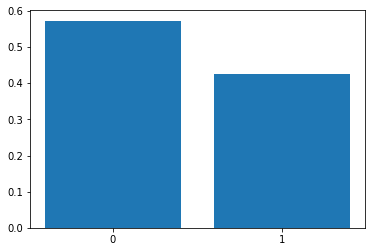

In [5]:
# checking collect_samples()
m, v, h, e = collect_samples(2, 1, debug=True)
plt.bar(e[:-1], h)
plt.xticks([0,1])
plt.show()

## Sampling from Binomial Distribution to plot a Bernoulli PDF

In [6]:
# Sample from the bionomial distribution to plot a Bernoulli PDF
def sample_binomial(p, n):
    distribution = [ c_of_n_x(n,z) * np.power(p, z) * np.power(1-p, n-z) for z in range(n+1)]
    return distribution

# supporting function for sample_binomial
def c_of_n_x(n,x):
    numerator = math.factorial(n)
    denominator = math.factorial(x) * math.factorial(n-x)
    return numerator/denominator

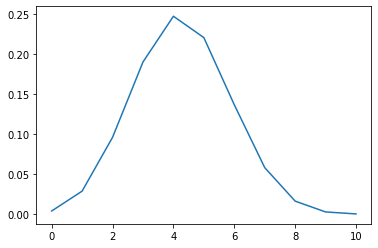

In [7]:
# checking our binomial distribution sampler
n_samples = 10
plt.plot(range(0,n_samples+1),sample_binomial(m, n_samples))
plt.show()

## Plotting many together

In [8]:
# run scenarios to generate data to plot
# colorcodes each scenario
# keeps track of descriptive stats (expectation value and variance)
def run_scenarios(scenarios, n_throws=10000, n_bins=10):
    # Important to keep the number of bins small otherwise Bernoulli is 
    # too confident / narrows out too much which is not reflected in our experiments

    x = range(n_bins+1)
    y = []
    c = []
    cm = plt.cm.get_cmap('YlOrRd')
    stats = []
    for i in range(len(scenarios)):
        scenarios[i].append(n_throws)
    for args in scenarios:
        m, s, h, e = collect_samples(*args)
        stats.append( [m, s] )
        y += [ sample_binomial(m, n_bins) ]
        c += [cm(m)]
    
    return x, y, c, stats, n_bins

In [9]:
# plotting stuff
def plot_ridgeplot(x, y, c, stats, names, n_bins):
    gs = (grid_spec.GridSpec(len(scenarios),1))
    hspace = -.5
    ymax = .4

    fig = plt.figure(figsize=(15,10))
    fig.suptitle("Probability Distribution of Attacker Loss per Attacker Wagered\nDefender Loss = 1 - Attacker Loss", fontsize=18, y=0.9)

    ax_objs = []
    for i in range(len(names)):
        # make a new axis and keep track of it in ax_objs
        ax_objs.append( fig.add_subplot(gs[i:i+1, 0:]) )
        ax = ax_objs[-1]
        # plot
        ax.plot(x, y[i])
        ax.fill_between(x,y[i], color = c[i])
        ax.set_ylim(0,ymax)
        ax.set_xlim(0,10)
        # make background transparent
        rect = ax.patch
        rect.set_alpha(0)
        # remove borders, axis ticks, labels
        ax.set_yticks([])
        ax.set_ylabel('')
        if i != len(names)-1:
            ax.set_xticks([])
        else:
            ax.set_xticks(range(0,n_bins+1))
            ax.set_xticklabels([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
            ax.set_xlabel("Attackers Lost")
            #attempting to make a bar showing .5 or the symetry point on top of all plots is a challenge for another day..
            #ax.set_ylim(0,ymax*len(names)*(-hspace))
            #ax.axvline(x=.5*n_bins, ymin=0, ymax=(len(names)*(-hspace)))
        for s in ['top','right','left','bottom']:
            ax.spines[s].set_visible(False) 
        ax.text(-0.2,0,names[i], fontweight='bold',fontsize=14,ha='right')
        ax.axvline(x=stats[i][0]*n_bins, ymin=0, ymax=.5, color='b')
        ax.axvline(x=(stats[i][0] * n_bins + stats[i][1]*n_bins), ymin=0, ymax=.2, color='w')
        ax.axvline(x=(stats[i][0] * n_bins - stats[i][1]*n_bins), ymin=0, ymax=.2, color='w')
        ax.text((stats[i][0]*n_bins + .15), 0.15 ,'{0:.2f}'.format(stats[i][0]))

    # make plots overlap eachother
    gs.update(hspace=hspace)

    plt.show()

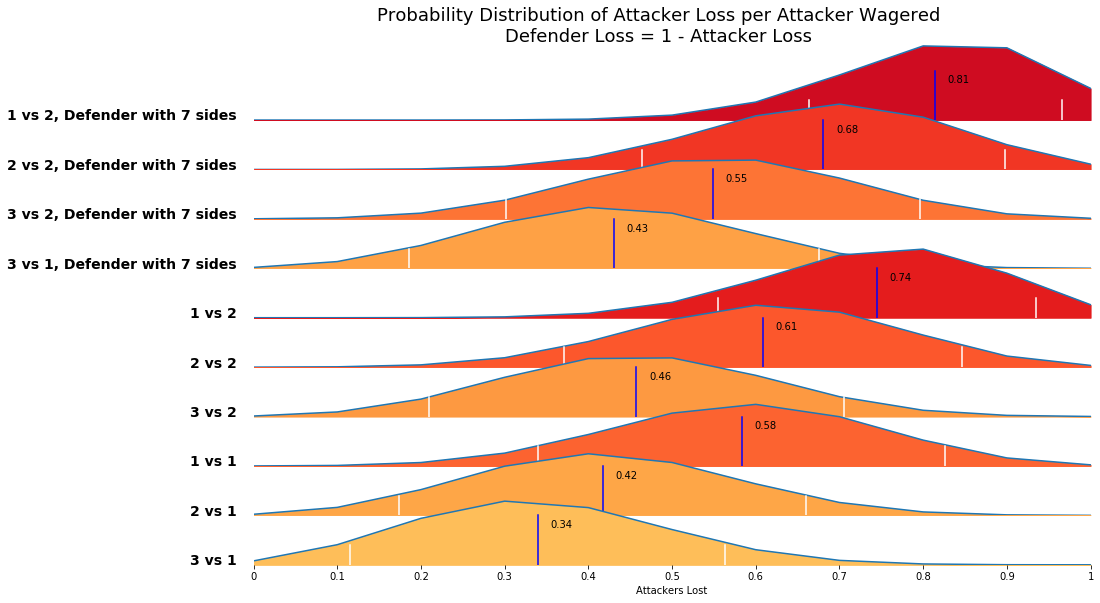

In [10]:
# specify tests we are going to run
scenarios = [
    [3,1, 6, 6],
    [2,1, 6, 6],
    [1,1, 6, 6],
    [3,2, 6, 6],
    [2,2, 6, 6],
    [1,2, 6, 6],
    [3,1, 6, 7],
    [3,2, 6, 7],
    [2,2, 6, 7],
    [1,2, 6, 7]
]
names = [
    '3 vs 1',
    '2 vs 1',
    '1 vs 1',
    '3 vs 2',
    '2 vs 2',
    '1 vs 2',
    '3 vs 1, Defender with 7 sides',
    '3 vs 2, Defender with 7 sides',
    '2 vs 2, Defender with 7 sides',
    '1 vs 2, Defender with 7 sides',
]
scenarios.reverse()
names.reverse()

x, y, c, stats, n_bins = run_scenarios(scenarios)
plot_ridgeplot(x,y,c,stats,names,n_bins)

# Conclusion
Having an expectation of how many troops you need to wager in order to make a successful attack is key to planning a strategy with Warfish. Knowing whether to stay put on high ground or attack downwards based on your losses (p) and your opponent's losses (1-p) can help pave the way to victory.

Consider the following situation:<br>![5vs3](img/5v3.png "5vs3")<br>
Blue, being worried that their defenses are about to be breached, can wait for brown to attack up, blue enjoys a 7-sided-dice hill defense bonus. Another option is being pro-active about attacking down at the looming threat, although this is just a normal 6-sided vs 6-sided attack. Checking our expected losses above we see that if blue uses the maximized attack-down option waging 3vs2 (n_a_sides=n_d_sides=6), they can expect to lose 0.46 attackers for every 1 wagered. If they wait for brown to attack up, brown using maximized '3vs2, Defender with 7 sides' tactic will lose .56 attackers for every one wagered. Since defender loss = 1-attacker loss, blue will lose .44 troops in this case. Comparing blue's losses, 0.46 for attacking first, or 0.44 for staying defensive, we can see there is a very small advantage in staying put with hill defensive bonus. 

Although it's important to be mindful! The variance on all these estimations is large, so while you might have the superior strategy backed by data, real dice rolls never listen to our wishes.

Finally, one must consider the cumulative effect of all attacks. Attacking multiple times with the same dynamics doesn't change the underlying probability function, however once defenses are down the attacker gets extra probability of success. Likewise attacking a strongly defended enemy with few resources left quickly leads to failure. Consideration of how these probabilities stack together in real rounds is considered in a previous workbook: [Warfish Dice-3 At Least Graphs.ipynb](https://github.com/ZacButko/Probability-Playground/blob/master/Warfish%20Dice/Warfish%20Dice-3%20At%20Least%20Graphs.ipynb)